## Group 25 
### Olof Sjögren, 7h
### Romain Theodet, 7h

# Question 1: Preprocessing

## a.
For now, we use all data provided, "as is", without filtering all the extra headers.


In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import glob

# Read all files in a directory and generate the data, merging the ham and the spam
def readFilesInDir(pathHam, pathSpam):
    # Data array, list of strings
    data = []   # ["email","email","email", "spam",...]
    # Whether each element is spam or not
    isSpam = [] # [False, False, False,True, ...]
    flag = True

    for path in (pathHam, pathSpam):
        # Get all files using regex
        allFiles = glob.glob(path)

        for filename in allFiles:
            with open(filename, mode="rb") as f:
                # Some files aren't encoded in proper UTF-8, so we use a small hack to load them,
                #  which is load them in binary and decode it while skipping bad characters
                content = f.read().decode(encoding="utf-8", errors="ignore")
                data.append(content)
                isSpam.append(flag)
        
        flag = not(flag)

    # Return the data as a dataframe
    return pd.DataFrame(list(zip(data, isSpam)), columns=["message","isSpam"])

easyData = readFilesInDir("data/easy_ham/*", "data/spam/*")
hardData = readFilesInDir("data/hard_ham/*", "data/spam/*")


To prepare the datasets for the model we read the easy ham files and spam files and mixed these together. We gave each entry a label as well to be able to distinguish spam and ham. The same was done with the hard spam files and again the spam files.
We mixed them together since we want to have a dataset we can train the model on.
The result is a dataframe with the structure:

| message                   | isSpam      |
| ------------------------- | ----------- |
| "... realEmailString ..." | False       |
| "... spamEmailString ..." | True        |
 
 -
We created 2 datasets: `easyData` and `hardData` with this data structure which will be used to train the classifier.

## b.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Shuffle the data
easyData = easyData.sample(frac=1.0, random_state=0)
hardData = hardData.sample(frac=1.0, random_state=0)

# Count vectorizer, transform the string data to a case-sensitive matrix
vectorizer = CountVectorizer(analyzer="word", lowercase=False)

easyHamTrain, easyHamTest, easySpamTrain, easySpamTest = train_test_split(
    vectorizer.fit_transform(easyData["message"]),
    easyData["isSpam"], 
    test_size=0.25,
    random_state=0,
)

hardHamTrain, hardHamTest, hardSpamTrain, hardSpamTest = train_test_split(
    vectorizer.fit_transform(hardData["message"]),
    hardData["isSpam"],
    test_size=0.25,
    random_state=0,
)


We decided to use the standard train/test size of 75% / 25%.
Furthermore, we vectorized the email text, counting the words in each email. The count is case sensitive since the use of capital letters might be an indicator of spam.

# Question 2 / 3: Bayes classifier

## a.
Training and testing sets were split in **1b**, see above.
## b.


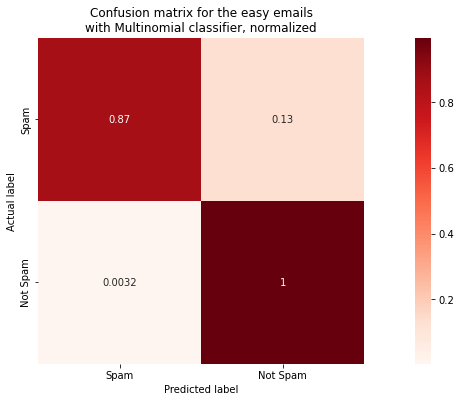

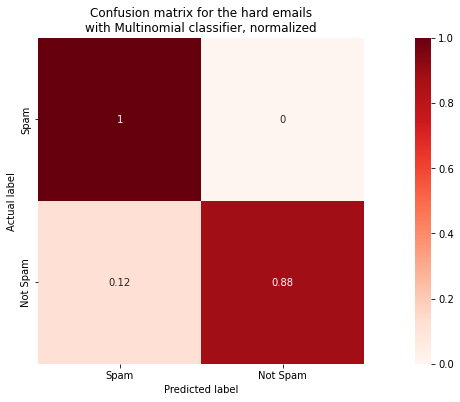

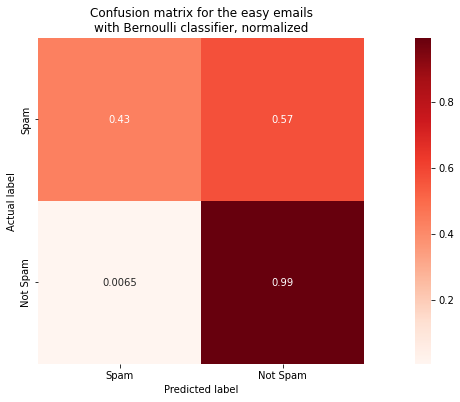

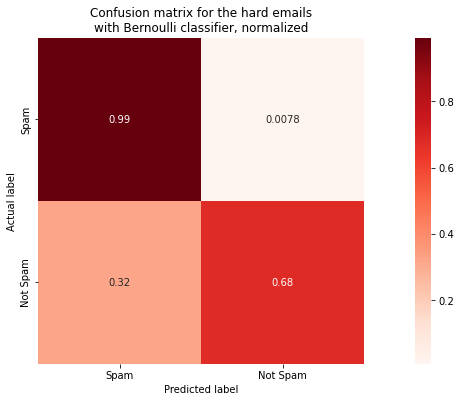

Multinomial easy email accuracy: 0.9747003994673769
Multinomial hard email accuracy: 0.9627659574468085
Bernoulli easy email accuracy:   0.8948069241011984
Bernoulli hard email accuracy:   0.8936170212765957


In [3]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Main function, will output the accuracy of a model and generate its confusion matrix 
def classify(X_train, y_train, X_test, y_test, model, title):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Predict the results
    y_pred = model.predict(X_test)

    # Compare the predicted results to the real ones
    accuracy = metrics.accuracy_score(y_test, y_pred)

    # Generate the confusion matrix based on the predictions and the actual results
    cm = metrics.confusion_matrix(y_test, y_pred, normalize="true")

    labels = ["Spam", "Not Spam"]

    plt.figure(figsize=(18, 6))
    sns.heatmap(cm, annot=True, square=True, cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.title("Confusion matrix for the " + title + " classifier, normalized")
    plt.show()

    return accuracy

multiAccEasy = classify(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, MultinomialNB(), "easy emails\nwith Multinomial")
multiAccHard = classify(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, MultinomialNB(), "hard emails\nwith Multinomial")
bernAccEasy = classify(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, BernoulliNB(), "easy emails\nwith Bernoulli")
bernAccHard = classify(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, BernoulliNB(), "hard emails\nwith Bernoulli")

print(f"Multinomial easy email accuracy: {multiAccEasy}")
print(f"Multinomial hard email accuracy: {multiAccHard}")
print(f"Bernoulli easy email accuracy:   {bernAccEasy}")
print(f"Bernoulli hard email accuracy:   {bernAccHard}")


The Multinomial Naive Bayes classifier had great accuracy both on the easy set as well as the hard set. There is an interesting difference between the classification of the easy and hard sets. For the easy classification, the classifier is great at identifying emails which are **not** spam correctly, it doesn't make many mistakes here. However it has a harder time classifying emails which **are** spam, some of these will be classified as legit altough they are spam.
Interestingly enough for the hard classifier, the opposite is true. This classifier will be stricter and no spam will be classified as legit or "ham". But since it is stricter, emails which are not spam will be classified as spam.
There is a dilemma choosing between the classifiers, does one want some spam to make it through the filter or does one want some legit emails to be classified as spam?

The Bernoulli Naive Bayes doesn't work as well, since for easy emails it has a majority of false negatives, and for the hard ones it isn't clear whether it is a true negative or a false positive. However, we found it interesting that the error "flips" between easy and hard emails, like the Multinomial classifier. With this classifier though, the flip is way more noticeable. 
Once again there is a dilemma of over- and under-classification of spam.
Note: we didn't add the `binarize` flag, since it led to worse accuracy score.

Overall, it seems pretty clear that the Multinomial classifier is better than the Bernoulli one, as the ratio of false positive and false negative is several times lower.

# Question 4: Words filtering

## a.

Filtering out common words might be useful to prevent bloating the matrix with useless information, or worse, classify uncommon words as noise. We don't want common/filler words to make up most of the data training the model since there is a higher chance they overlap and in a spam email and a legit email. Filtering out these words also makes the model train faster as it does not have to take these filler words into account which carry no value in the distinction between a spam and a legit email.

For example, common words like `the` or `a` will probably have the same repartition in both messages,
as they are simply building blocks of the english language.
However, words related to winning, diseases or sexual practices will probably be way more frequent in spam emails, and shouldn't be treated as background noise.

We can find some of the common words in the data set by looking at the vectorized words.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer="word", lowercase=False)
matrix = vectorizer.fit_transform(easyData["message"])

# Count the number of occurences of each word.
counts = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out()).sum()
# Sort on the most number of occurences.
counts.sort_values(axis=0, ascending=False, inplace=True)

print(f"The most common words are: \n")
print(counts.head(10))

print("\n\n")

# Sort on the least number of occurences.
counts.sort_values(axis=0, ascending=True, inplace=True)
print(f"The least common words are: \n")
print(counts.head(10))


The most common words are: 

com     31077
the     26108
org     25475
2002    25369
net     20368
from    19262
with    19239
for     18928
to      18628
by      18585
dtype: int64



The least common words are: 

g8CM                         1
HAy6fR                       1
HDIb                         1
HDJ87LWgkZpgE                1
HDRpP                        1
HEmyxERAhF0sSU               1
HEffvDVPjRgC65XtiBLs5Jy      1
HEWbbD0gzFT                  1
7KMt1RXObLXySsaG4bHqAPfk6    1
HESITATE                     1
dtype: int64


Using `CountVectorizer` to find the 10 most frequent words we do indeed find common words such as `the`, `for`, `to`, `by` as we predicted. We also see odd words such as `com`, probably extracted from the email adress in the meta data, and `2002` also probably from the meta data since the emails seems to be sent during the year 2002.

Looking at the 10 least common words we can also see why it is important to filter out text. Many of them are gibberish and do not actually mean anything, they are most likely part of meta data from the email. Although the unique word `HESITATE` shown might be important for the model and will be lost in any filtering.


## b.

The filtering of words was done in two steps using Sklean's CountVectorizer. The filtering used different higher and lower threshold of word occurences.

The first step was to run the model multiple time while adjusting the lower word frequency threshold (i.e. `min_df`) each time. The accuracy of the model was saved for each frequency tested and the resulting list of accuracies for the different values for the `min_df` parameter were then plotted to visualize the results for the different frequencies.

The same process was repeated for the higher word frequency threshold (i.e. `max_df`). For this step the lower frequency used was the one giving the best result in the first step. This while, simliarly to the first step, altering the higher frequency threshold.

The different threshold used in the steps were arbitrarily chosen. The only requirement was to get a spike at some point, to clearly see that before some threshold it gets better and then gets worse.

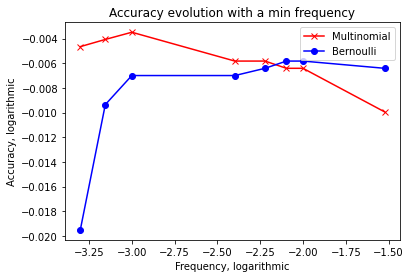

In [5]:
import math

# Calculate different accuracies
accuraciesM = []
accuraciesB = []

# The different frequencies tested.
freqs = (0.0005, 0.0007, 0.001, 0.004, 0.006, 0.008, 0.01, 0.03)

for freq in freqs:
    # We vary the minimum frequency
    vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=0.75, min_df=freq)

    xTrain, xTest, yTrain, yTest = train_test_split(
        vectorizer.fit_transform(easyData["message"]),
        easyData["isSpam"], 
        test_size=0.25,
        random_state=0,
    )

    modelM = MultinomialNB()
    modelM.fit(xTrain, yTrain)

    modelB = BernoulliNB()
    modelB.fit(xTrain, yTrain)

    yPred = modelB.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesB.append(math.log(accuracy, 10))

    yPred = modelM.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesM.append(math.log(accuracy, 10))

# Plotting the graph
plt.plot([math.log(f, 10) for f in freqs], accuraciesM, c="red", marker="x", label="Multinomial")
plt.plot([math.log(f, 10) for f in freqs], accuraciesB, c="blue", marker="o", label="Bernoulli")
plt.xlabel("Frequency, logarithmic")
plt.ylabel("Accuracy, logarithmic")
plt.title("Accuracy evolution with a min frequency")
plt.legend()
plt.show()


The different accuracies are plotted above.
The shared best lower threshold can roughly be estimated to be between `-2.25` and `-2.00` on the logarithmic scale, meaning around `0.005` should be an appropriate lower threshold.

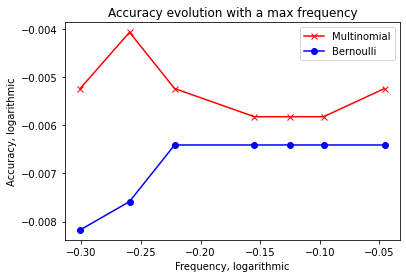

In [6]:
# Accuracies for Multinomial and Bernoulli
accuraciesM = []
accuraciesB = []

# The different frequencies tested.
freqs = (0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.9)

for freq in freqs:
    # We change the max frequency
    vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=freq, min_df=0.005)

    xTrain, xTest, yTrain, yTest = train_test_split(
        vectorizer.fit_transform(easyData["message"]),
        easyData["isSpam"], 
        test_size=0.25,
        random_state=0,
    )

    modelM = MultinomialNB()
    modelM.fit(xTrain, yTrain)

    modelB = BernoulliNB()
    modelB.fit(xTrain, yTrain)

    yPred = modelB.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesB.append(math.log(accuracy, 10))

    yPred = modelM.predict(xTest)
    accuracy = metrics.accuracy_score(yTest, yPred)
    accuraciesM.append(math.log(accuracy, 10))

# Plotting the graph
plt.plot([math.log(f, 10) for f in freqs], accuraciesM, c="red", marker="x", label="Multinomial")
plt.plot([math.log(f, 10) for f in freqs], accuraciesB, c="blue", marker="o", label="Bernoulli")
plt.xlabel("Frequency, logarithmic")
plt.ylabel("Accuracy, logarithmic")
plt.title("Accuracy evolution with a max frequency")
plt.legend()
plt.show()


From this plot, `0.6` was determined to be an appropriate higher threshold as both model share a relatively high accuracy here (just before `-0.20` on the logarithmic scale).

Below are the final models with the determined thresholds as parameters.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics

vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=0.6, min_df=0.005)

easyHamTrain, easyHamTest, easySpamTrain, easySpamTest = train_test_split(
    vectorizer.fit_transform(easyData["message"]),
    easyData["isSpam"], 
    test_size=0.25,
    random_state=0,
)

hardHamTrain, hardHamTest, hardSpamTrain, hardSpamTest = train_test_split(
    vectorizer.fit_transform(hardData["message"]),
    hardData["isSpam"],
    test_size=0.25,
    random_state=0,
)

# Return the accuracy of training / test sets with a given model
def getAccuracy(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    yPred = model.predict(X_test)
    return metrics.accuracy_score(y_test, yPred)

print("Final accuracies, with adapted parameters:\n")

multiAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, MultinomialNB())
print(f"Multinomial easy email accuracy: {multiAccEasy}")

multiAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, MultinomialNB())
print(f"Multinomial hard email accuracy: {multiAccHard}")

bernAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, BernoulliNB())
print(f"Bernoulli easy email accuracy:   {bernAccEasy}")

bernAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, BernoulliNB())
print(f"Bernoulli hard email accuracy:   {bernAccHard}")

Final accuracies, with adapted parameters:

Multinomial easy email accuracy: 0.9880159786950732
Multinomial hard email accuracy: 0.9574468085106383
Bernoulli easy email accuracy:   0.9853528628495339
Bernoulli hard email accuracy:   0.9308510638297872




Compared to the results from b, the accuracy for the **Multinomial** has increased for the easy emails and is almost 100% accurate. Although the accuracy has slightly dropped for the hard emails. The **Bernoulli** also has a significant increase in the accuracy for the easy emails as well as for the hard emails (although not as high).

Filtering seems to be great for the accuracy of the easy email and spam detection. However it does not work as well on the hard email sets where the accuracy suffers.


# Question 5: Content filtering
## a.

In [8]:
import email

# Remove the useless headers from a mail
def processMail(mailStr):
    # Parse email
    mailObj = email.message_from_string(mailStr)
    result = ""

    # We still want to include some useful headers
    result += "From: "        + mailObj.get("From",        "") + "\n"
    result += "Subject: "     + mailObj.get("Subject",     "") + "\n"
    result += "Sender: "      + mailObj.get("Sender",      "") + "\n"
    result += "Message-ID: "  + mailObj.get("Message-ID",  "") + "\n"
    result += "Cc: "          + mailObj.get("Cc",          "") + "\n"
    result += "In-Reply-To: " + mailObj.get("In-Reply-To", "") + "\n"

    # Get content, which is either a string or a list of strings
    payload = mailObj.get_payload()

    if type(payload) is list:
        # For each element we add it to the result
        for elt in payload:
            result += str(elt) + "\n"
    else:
        result += str(payload)
    
    return result

easyDataClean = pd.DataFrame([], columns=["message","isSpam"])
easyDataClean["message"] = easyData["message"].apply(processMail)
easyDataClean["isSpam"]  = easyData["isSpam"]

hardDataClean = pd.DataFrame([], columns=["message","isSpam"])
hardDataClean["message"] = hardData["message"].apply(processMail)
hardDataClean["isSpam"]  = hardData["isSpam"]

print(f"An arbitrary easy/spam email after cleaning:\n")
print(easyDataClean["message"].iloc[0])

An arbitrary easy/spam email after cleaning:

From: James Rogers <jamesr@best.com>
Subject: Re: Digital radio playlists are prohibited?!
Sender: fork-admin@xent.com
Message-ID: <1032995753.27386.88.camel@avalon>
Cc: 
In-Reply-To: <132203498905.20020925163453@magnesium.net>
On Wed, 2002-09-25 at 13:34, bitbitch@magnesium.net wrote:
> 
> This, kiddies was apparently the legislative beginnings of the whole
> streaming audio-gets-spanked-by-fees ruling that came down in the
> earlier parts of this year.  This first act applied to non-exempt,
> non-subscription transmission services.  When Congress got around in
> 1998 and realized that webcasting services -might- be different
> (though I honestly can't see how) they wrote in the provision through
> the DMCA to include such transmissions.


The restrictive law regarding audio is actually the accumulated cruft of
30 years of various legislative acts. The totality of what we have now
come from various parts of all the following re: sound reco

To clean the data, we took the "dirty" data and only kept the payload of the email with some headers selected by hand, like `From` or `Subject`.

In [9]:
# Naive vectorizer
vectorizer = CountVectorizer(analyzer="word", lowercase=False)

easyHamTrain, easyHamTest, easySpamTrain, easySpamTest = train_test_split(
    vectorizer.fit_transform(easyDataClean["message"]),
    easyDataClean["isSpam"], 
    test_size=0.25,
    random_state=0,
)

hardHamTrain, hardHamTest, hardSpamTrain, hardSpamTest = train_test_split(
    vectorizer.fit_transform(hardDataClean["message"]),
    hardDataClean["isSpam"],
    test_size=0.25,
    random_state=0,
)

print("Final accuracies, without adapted parameters, on clean data:\n")

multiAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, MultinomialNB())
print(f"Multinomial easy email accuracy: {multiAccEasy}")

multiAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, MultinomialNB())
print(f"Multinomial hard email accuracy: {multiAccHard}")

bernAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, BernoulliNB())
print(f"Bernoulli easy email accuracy:   {bernAccEasy}")

bernAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, BernoulliNB())
print(f"Bernoulli hard email accuracy:   {bernAccHard}")



# Tailored vectorizer from part 4
vectorizer = CountVectorizer(analyzer="word", lowercase=False, max_df=0.6, min_df=0.005)

easyHamTrain, easyHamTest, easySpamTrain, easySpamTest = train_test_split(
    vectorizer.fit_transform(easyDataClean["message"]),
    easyDataClean["isSpam"], 
    test_size=0.25,
    random_state=0,
)

hardHamTrain, hardHamTest, hardSpamTrain, hardSpamTest = train_test_split(
    vectorizer.fit_transform(hardDataClean["message"]),
    hardDataClean["isSpam"],
    test_size=0.25,
    random_state=0,
)

print("\n\nFinal accuracies, with adapted parameters, on clean data:\n")

multiAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, MultinomialNB())
print(f"Multinomial easy email accuracy: {multiAccEasy}")

multiAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, MultinomialNB())
print(f"Multinomial hard email accuracy: {multiAccHard}")

bernAccEasy = getAccuracy(easyHamTrain, easySpamTrain, easyHamTest, easySpamTest, BernoulliNB())
print(f"Bernoulli easy email accuracy:   {bernAccEasy}")

bernAccHard = getAccuracy(hardHamTrain, hardSpamTrain, hardHamTest, hardSpamTest, BernoulliNB())
print(f"Bernoulli hard email accuracy:   {bernAccHard}")


Final accuracies, without adapted parameters, on clean data:

Multinomial easy email accuracy: 0.9693741677762983
Multinomial hard email accuracy: 0.9414893617021277
Bernoulli easy email accuracy:   0.8881491344873502
Bernoulli hard email accuracy:   0.8882978723404256


Final accuracies, with adapted parameters, on clean data:

Multinomial easy email accuracy: 0.9733688415446072
Multinomial hard email accuracy: 0.9361702127659575
Bernoulli easy email accuracy:   0.9587217043941412
Bernoulli hard email accuracy:   0.925531914893617


Comparing the results with the results from 3 the **Multinomial** actually performes worse in both the hard and easy case, bot with adapted and unadapted paramters. **Bernoulli** gives better results than 3 if the parameters are also adapted using the ones from 4.

Looking at the results from 4, the results for the **Multinomial** are also worse, again with both adapted and unadapted paramters. Here, the results for the **Bernoulli** from 4 are also better.

This is a bit surprising, but we can find some explainations. First, with the frequency limits, all the obscure gibberish from the header was already removed. Then, without these limits, we might not know about all existing headers ; the model probably gets some additional information from what would seem pointless for us.


## b.
What can happen is that, when splitting the dataset into test and training sets, the types of emails are unproporitional in the test and training sets. So for example we might end up with the majority of the spam messages in the test set and the majority of the ham messsages in the training set. This will lead to a skewed model which is great at identifying ham messages since that's what it was mostly trained on, while struggling at identifying spam messages. 

A possible remedy for this is to ensure the types are equally distributed in the test set and the data set. This is called a stratified sample and the `stratify=` parameter for `train_test_split(...)` can be used to ensure this.

## c.

If our training set were mostly spam messages while our test set were mostly ham messages, our model wouldn't be able to correctly differentiate ham and spam, since it would have encountered way less ham while training.
This kind of overfitting would lead to bad accuracy and a lot of false positives / false negatives, as it would tend to caracterize a majority of the test set as spam. This kind of model could be really harmful in some critical environments like self-drving. To solve it, we "simply" have to split the sets in somehow equivalent subsets, which is easier done with large amount of data.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab83f1d1-4f39-4251-b899-1ad25d544179' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>